In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score


In [2]:
data = pd.read_csv('v2x_dataset.csv')

message_type_encoder = LabelEncoder()
priority_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Encode 'Message Type' column
data['Message Type'] = message_type_encoder.fit_transform(data['Message Type'])

# Split 'Message Content' column into a list of floats
data['Message Content'] = data['Message Content'].apply(lambda x: [float(i) for i in str(x).split(',')])

# Encode 'Priority' column
data['Priority'] = priority_encoder.fit_transform(data['Priority'])

# Select columns for training
columns_to_use = ['Message Type', 'Message Content', 'Priority', 'Source Vehicle', 'Destination Vehicle']

X = data[columns_to_use].values
y = data['label'].values

# Shuffle the data
shuffled_indices = np.arange(X.shape[0])
np.random.shuffle(shuffled_indices)
X = X[shuffled_indices]
y = y[shuffled_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [3]:
print(f'X_train shape: {X_train.shape}')

X_train shape: (8500, 5)


In [4]:
# Normalize the Message Content feature
X_train[:, 1] = list(scaler.fit_transform(np.array(X_train[:, 1].tolist())))
X_test[:, 1] = list(scaler.transform(np.array(X_test[:, 1].tolist())))

# Reshape the input for the fully connected neural network
X_train = np.array([np.array([x[0], *x[1], x[2]]) for x in X_train])
X_test = np.array([np.array([x[0], *x[1], x[2]]) for x in X_test])

In [5]:
X_test

array([[3.        , 0.77027703, 0.        ],
       [3.        , 0.88658866, 2.        ],
       [3.        , 0.25352535, 2.        ],
       ...,
       [3.        , 0.84708471, 0.        ],
       [3.        , 0.75217522, 2.        ],
       [3.        , 0.80148015, 1.        ]])

In [6]:
# Save the encoders and scaler
with open('message_type_encoder.pkl', 'wb') as f:
    pickle.dump(message_type_encoder, f)

with open('priority_encoder.pkl', 'wb') as f:
    pickle.dump(priority_encoder, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [7]:
# Build the fully connected neural network model
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                64        
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.15, callbacks=[EarlyStopping(patience=2)], verbose=1)

Epoch 1/10


2023-06-29 19:37:34.273789: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


226/226 [==============================] - 3s 10ms/step - loss: 0.6739 - accuracy: 0.5920 - val_loss: 0.6182 - val_accuracy: 0.6792
Epoch 2/10
226/226 [==============================] - 2s 8ms/step - loss: 0.5731 - accuracy: 0.7063 - val_loss: 0.5213 - val_accuracy: 0.7506
Epoch 3/10
226/226 [==============================] - 2s 8ms/step - loss: 0.4883 - accuracy: 0.7772 - val_loss: 0.4486 - val_accuracy: 0.7741
Epoch 4/10
226/226 [==============================] - 2s 8ms/step - loss: 0.4247 - accuracy: 0.8296 - val_loss: 0.3905 - val_accuracy: 0.7780
Epoch 5/10
226/226 [==============================] - 2s 8ms/step - loss: 0.3676 - accuracy: 0.8591 - val_loss: 0.3229 - val_accuracy: 0.8941
Epoch 6/10
226/226 [==============================] - 2s 8ms/step - loss: 0.3355 - accuracy: 0.8767 - val_loss: 0.2761 - val_accuracy: 0.8941
Epoch 7/10
226/226 [==============================] - 2s 9ms/step - loss: 0.3164 - accuracy: 0.8842 - val_loss: 0.2394 - val_accuracy: 0.8941
Epoch 8/10
226/2

In [10]:
# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

47/47 [==============================] - 0s 8ms/step - loss: 0.1746 - accuracy: 0.9600
Test accuracy: 0.96


In [11]:
# model.save('ids.h5')

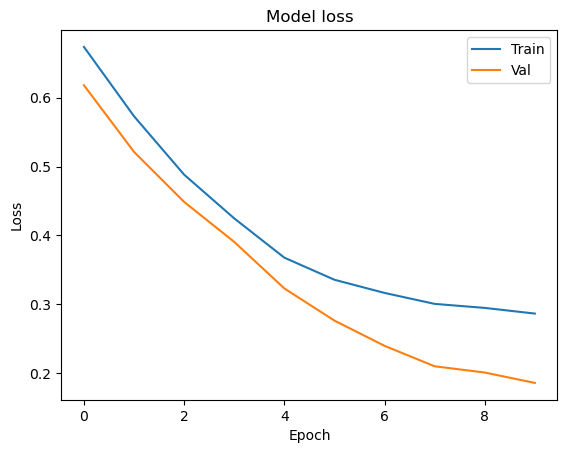

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

266/266 [==============================] - 1s 2ms/step


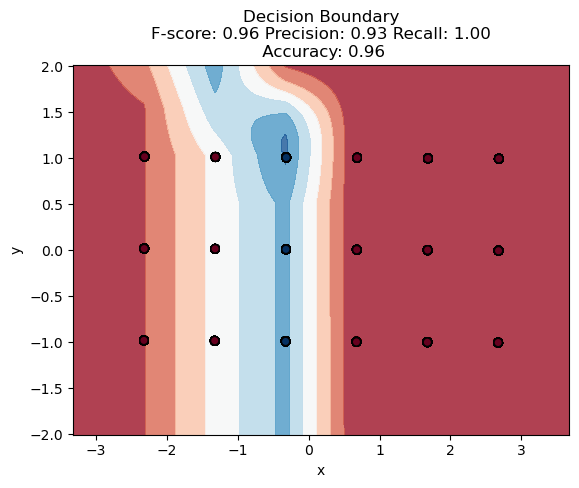

In [13]:

# Apply PCA to reduce the dimensionality of the data to 2D
pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(X_train)

# Create a meshgrid for the 2D plane
h = .02  # step size in the mesh
x_min, x_max = X_pca_train[:, 0].min() - 1, X_pca_train[:, 0].max() + 1
y_min, y_max = X_pca_train[:, 1].min() - 1, X_pca_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max,),
                     np.arange(y_min, y_max, h))

# Predict the class probabilities for each point in the meshgrid
Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Calculate performance metrics
pred_labels = np.where(model.predict(X_train) > 0.5, 1, 0)
f_score = f1_score(y_train, pred_labels)
precision = precision_score(y_train, pred_labels)
recall = recall_score(y_train, pred_labels)

# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.8)
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolors='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Decision Boundary\nF-score: {f_score:.2f} Precision: {precision:.2f} Recall: {recall:.2f}\n Accuracy: {accuracy:.2f}')
plt.show()


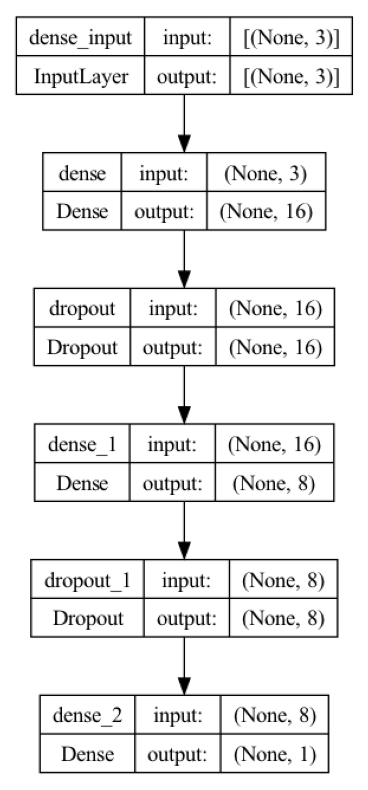

In [14]:
from tensorflow.keras.utils import plot_model
import pydotplus

# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Load the generated image
image = plt.imread('model.png')

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

266/266 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'Decision Boundary\nAUC-ROC: 1.00 F-score: 0.96 Precision: 0.93 Recall: 1.00\n Accuracy: 0.96')

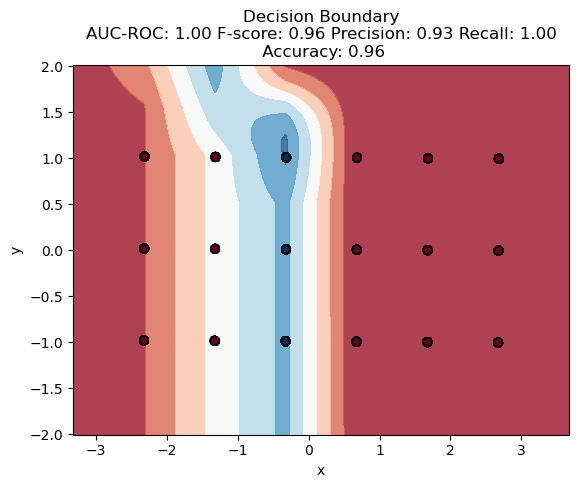

In [15]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, confusion_matrix

# Apply PCA to reduce the dimensionality of the data to 2D
pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(X_train)

# Create a meshgrid for the 2D plane
h = .02  # step size in the mesh
x_min, x_max = X_pca_train[:, 0].min() - 1, X_pca_train[:, 0].max() + 1
y_min, y_max = X_pca_train[:, 1].min() - 1, X_pca_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max,),
                     np.arange(y_min, y_max, h))

# Predict the class probabilities for each point in the meshgrid
Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Calculate performance metrics
fpr, tpr, thresholds = roc_curve(y_train, model.predict(X_train))
auc_score = auc(fpr, tpr)
pred_labels = np.where(model.predict(X_train) > 0.5, 1, 0)
f_score = f1_score(y_train, pred_labels)
precision = precision_score(y_train, pred_labels)
recall = recall_score(y_train, pred_labels)
conf_matrix = confusion_matrix(y_train, pred_labels)

# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.8)
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolors='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Decision Boundary\nAUC-ROC: {auc_score:.2f} F-score: {f_score:.2f} Precision: {precision:.2f} Recall: {recall:.2f}\n Accuracy: {accuracy:.2f}')


266/266 [==============================] - 1s 2ms/step


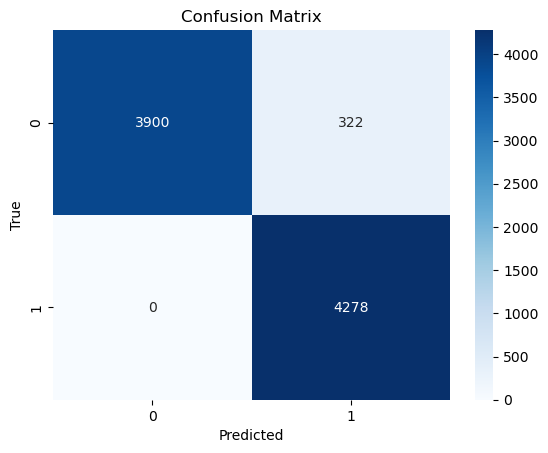

In [16]:

import seaborn as sns

# Calculate the predicted labels
pred_labels = np.where(model.predict(X_train) > 0.5, 1, 0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_train, pred_labels)

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [17]:
# import plotly.graph_objs as go

# # Create a 3D scatter plot of the 'Priority', 'Message Type', and 'Message Content' columns against 'Label'
# fig = go.Figure(data=[go.Scatter3d(
#     x=df['Message Type'],
#     y=df['Message Content'],
#     z=df['Priority'],
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=df['label'],
#         colorscale='Viridis',
#         opacity=0.8
#     )
# )])

# # Add a title and axis labels
# fig.update_layout(
#     title='Relationship between Priority, Message Type, Message Content, and Label',
#     scene=dict(
#         xaxis_title='Message Type',
#         yaxis_title='Message Content',
#         zaxis_title='Priority'
#     )
# )

# # Display the plot
# fig.show()

In [18]:
# import plotly.express as px

# # Create a scatter plot matrix of the 'Priority', 'Message Type', and 'Message Content' columns against 'Label'
# fig = px.scatter_matrix(
#     df,
#     dimensions=['Priority', 'Message Type', 'Message Content'],
#     color='label',
#     title='Relationship between Priority, Message Type, Message Content, and Label'
# )

# # Display the plot
# fig.show()

In [19]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           3
               Dense   XXXXX -------------------        64    30.6%
                relu   #####          16
             Dropout    | || -------------------         0     0.0%
                       #####          16
               Dense   XXXXX -------------------       136    65.1%
                relu   #####           8
             Dropout    | || -------------------         0     0.0%
                       #####           8
               Dense   XXXXX -------------------         9     4.3%
             sigmoid   #####           1
